In [13]:
# Number of data points to plot
num_points = 10

# Parameter ranges below
gc_actual = 0.1
gc_lo = 0.05
gc_hi = 0.5

ggap_actual = 1.0
ggap_lo = 0.5
ggap_hi = 1.5

gsyn_actual = 1.0
gsyn_lo = 0.5
gsyn_hi = 1.5

C_actual = 0.015

Iteration 1/10 took 2.96s
Iteration 2/10 took 2.44s
Iteration 3/10 took 1.97s
Iteration 4/10 took 2.02s
Iteration 5/10 took 1.73s
Iteration 6/10 took 1.60s
Iteration 7/10 took 1.27s
Iteration 8/10 took 1.08s
Iteration 9/10 took 0.90s
Iteration 10/10 took 0.88s


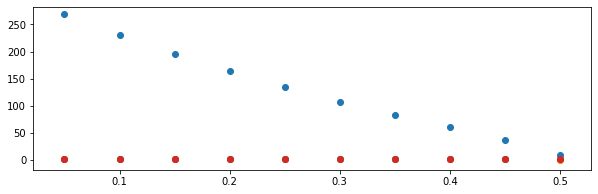

In [19]:
import numpy as np
import pandas as pd
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

param_vals = []
dom_amplitude_vals = []
dom_amplitude_convergence_vals = []
dom_period_vals = []
dimensionality_vals = []

i = 0
for gc in np.linspace(gc_lo, gc_hi, num_points):
  i += 1
  start_time = time.time()
  fwd_dynamics = simulate_until_stable(
    C = C_actual, Gc = gc, ggap = ggap_actual, gsyn = gsyn_actual)
  elapsed_time = time.time() - start_time
  print("Iteration {0}/{1} took {2:.2f}s".format(i, num_points, elapsed_time))

  n = fwd_dynamics.shape[0]
  X = fwd_dynamics - fwd_dynamics.mean(axis = 0)
  pca = PCA()
  projected_X = pca.fit_transform(fwd_dynamics)
  dom_mode = projected_X[:,0]
  dom_amplitude = get_amplitude(dom_mode)
  dom_amplitude_convergence = get_amplitude_convergence(dom_mode)
  dom_period = get_period(dom_mode)
  eigen_vals = get_eigenvalues_from_pca(pca, n)
  dimensionality = get_dimensionality(eigen_vals)
  
  param_vals.append(gc)
  dom_amplitude_vals.append(dom_amplitude)
  dom_amplitude_convergence_vals.append(dom_amplitude_convergence)
  dom_period_vals.append(dom_period)
  dimensionality_vals.append(dimensionality)

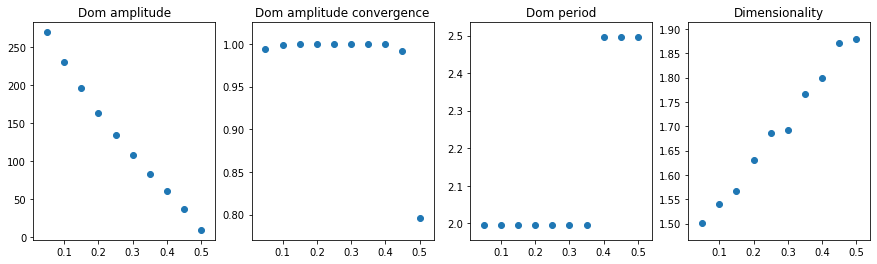

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
ax = axes[0]
ax.scatter(param_vals, dom_amplitude_vals)
ax.set_title("Dom amplitude")
ax = axes[1]
ax.scatter(param_vals, dom_amplitude_convergence_vals)
ax.set_title("Dom amplitude convergence")
ax = axes[2]
ax.scatter(param_vals, dom_period_vals)
ax.set_title("Dom period")
ax = axes[3]
ax.scatter(param_vals, dimensionality_vals)
_ = ax.set_title("Dimensionality")